In [1]:
!pip install torch torchvision
!pip install trimesh
#!pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0
!pip install celluloid
!pip install tqdm

     |████████████████████████████████| 639 kB 6.4 MB/s 


***Импорт библиотек***


In [32]:
import os
import pytorch3d
import sys
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# You should work in Jupyter.
from tqdm import tqdm_notebook

from celluloid import Camera

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
#from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import TexturesUV, TexturesVertex, TexturesAtlas

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

import trimesh
from trimesh import registration
from trimesh import visual

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

In [5]:
!mkdir data

In [17]:
!wget -nc -P ./data/ https://raw.githubusercontent.com/GalyuginAlexey/3D_ML/main/Homework%20%E2%84%961/Tiger.obj -O 'Tiger.obj'
!mv ./Tiger.obj ./data/

File ‘Tiger.obj’ already there; not retrieving.


In [18]:
path_to_model = os.path.join("data", "Tiger.obj")

****Подготовка моделей****

In [19]:
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the chair.
Tiger_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [22]:
sphere_mesh = ico_sphere(4, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
#verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = TexturesVertex(verts_features=verts_rgb.to(device))

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [23]:
num_points_to_sample = 25000

Tiger_vert, Tiger_norm = sample_points_from_meshes(
    Tiger_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

In [24]:
def convert_to_mesh(mesh):
    """Trimesh может загружать сцены вместо монолитного объекта
    """
    if isinstance(mesh, trimesh.Scene):
        return mesh.dump(concatenate=True)
    else:
        return mesh
    
def scale_to_unit(mesh: trimesh.Trimesh):
    length, weight, height = mesh.extents
    scale = 1 / max(length, weight, height)
    mesh.apply_scale((scale, scale, scale))

***Рендеринг полигональных моделей***

In [25]:
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

In [26]:
image_Tiger = phong_renderer(meshes_world=Tiger_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_Tiger = image_Tiger.cpu().numpy()

****Из какой фигуры****


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


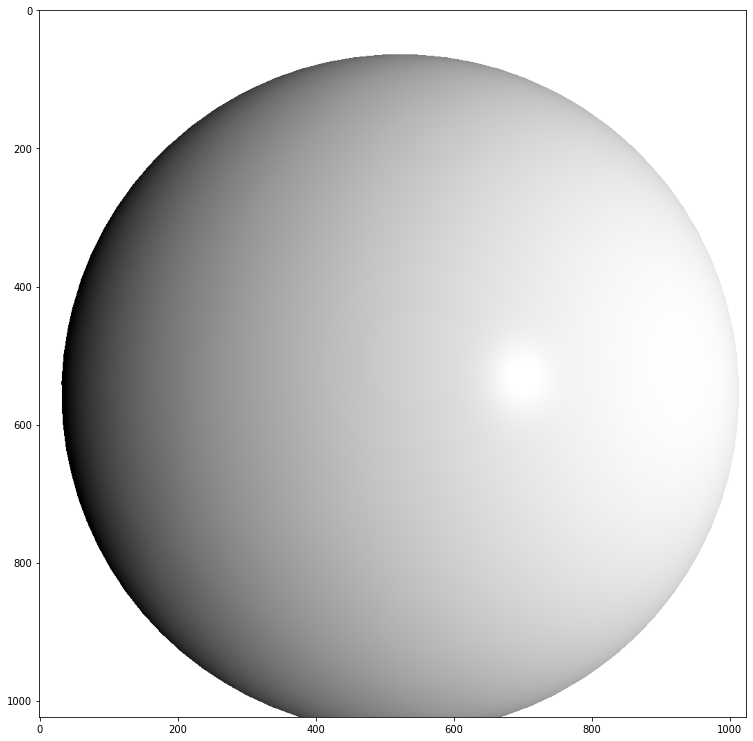

In [27]:
plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

****В какую фигуру****

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


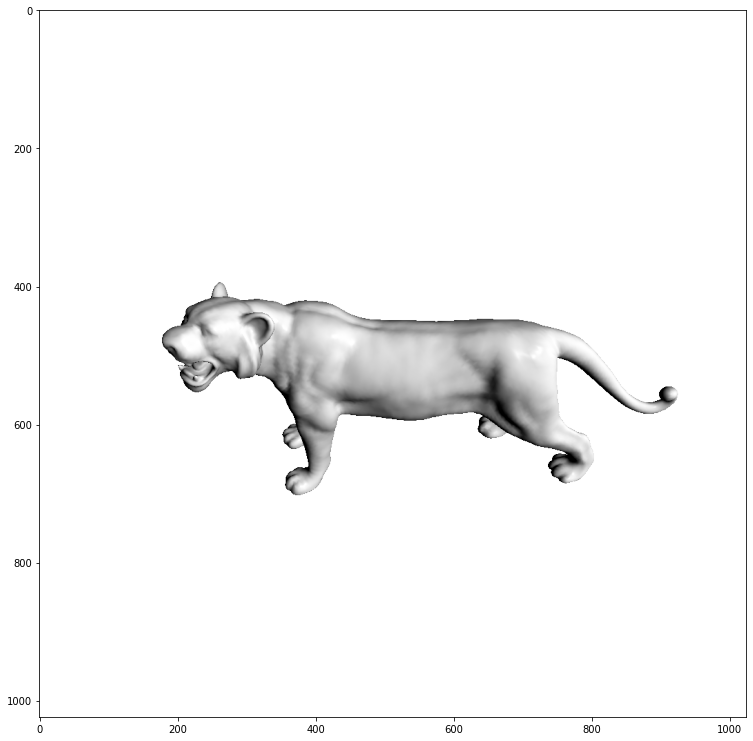

In [28]:
plt.figure(figsize=(13, 13))
plt.imshow(image_Tiger.squeeze())
plt.grid(False)

****Эксперимент с деформацией модели****

In [29]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

****Зафиксируем параметры оптимизационного процесса****


In [30]:
# Number of optimization steps
Niter = 1001
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/1001 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow

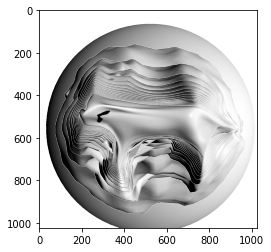

In [31]:
loop = tqdm_notebook(range(Niter))

fig = plt.figure()
camera = Camera(fig)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(Tiger_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the bunny providing the values of R and T. 
        image_bunny = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_bunny = image_bunny.detach().cpu().numpy()

        plt.imshow(image_bunny.squeeze())
        plt.grid(False)
        camera.snap()

    # Optimization step
    loss.backward()
    optimizer.step()